In [1]:
import os
pdf_path = os.path.join('..', 'data', 'assignment.pdf')

if os.path.isfile(pdf_path):
    print(f"File found: {pdf_path}")
else:
    print(f"File not found: {pdf_path}")
print(f"Current working directory: {os.getcwd()}")


File found: ../data/assignment.pdf
Current working directory: /home/ago/Learning/LLM/SemanticSearchwithRAG/src


Data Extraction from PDF

In [2]:
from langchain.document_loaders import PyPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
import fitz


def extract_text_and_images(pdf_path, output_folder='images', chunk_size=1000, chunk_overlap=150):
    
    """
    Extracts text and images from a PDF file.

    Args:
        pdf_path (str): Path to the input PDF file.
        output_folder (str): Directory where images will be saved. Defaults to 'images'.
        chunk_size (int): The maximum size of text chunks. Defaults to 1000 characters.
        chunk_overlap (int): The overlap size between text chunks. Defaults to 150 characters.

    Returns:
        tuple: A tuple containing a list of text chunks and a list of image file paths.
    """
        
    
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Initialize the PDF loader
    loader = PyPDFLoader(pdf_path)
    pages = loader.load()

    # Initialize the text splitter
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=chunk_size, chunk_overlap=chunk_overlap, length_function=len
    )

    # List to store text Chunks and Images
    text_chunks = []
    images = []
    # Extract text chunks from pages
    for page in pages:
        chunks = text_splitter.split_documents([page])
        text_chunks.extend(chunks)
    

    # Extract and save images
    pdf_document = fitz.open(pdf_path)
    for page_number in range(len(pdf_document)):
        page = pdf_document.load_page(page_number)
        image_list = page.get_images(full=True)
        for img_index, image in enumerate(image_list):
            xref = image[0]
            base_image = pdf_document.extract_image(xref)
            image_bytes = base_image["image"]
            image_filename = os.path.join(output_folder, f'page_{page_number+1}_image_{img_index+1}.png')
            
            # Save image
            with open(image_filename, "wb") as img_file:
                img_file.write(image_bytes)
            # print(f"Saved image {image_filename}")
            images.append(image_filename)

    pdf_document.close()
    return text_chunks, images




In [3]:
chunks,image_path = extract_text_and_images(pdf_path)
# print(f"Total text chunks: {len(chunks)}")
# print(f"Total images chunks: {len(image_path)}")
# print(type(image_path))

Embedding Function 

In [4]:
from langchain_experimental.open_clip import OpenCLIPEmbeddings

embedding_clip = OpenCLIPEmbeddings(model_name="ViT-g-14", checkpoint="laion2b_s34b_b88k")
# embedding_clip = OpenCLIPEmbeddings(model_name="ViT-H-14-378-quickgelu", checkpoint="dfn5b") # better on paper


Database Setup

In [5]:
from langchain.vectorstores import Chroma

db = Chroma.from_documents(chunks,embedding_clip,persist_directory ='datastore' )


Preparing and adding images to database

In [6]:
import hashlib

for path in image_path:
    # image_id = hashlib.md5(path.encode()).hexdigest()
    # Creating metadata
    metadata = {
        'page': 'image',
        'source': path
    }
    db.add_images([path],[metadata])
        

In [7]:
db.search(query="paper released over years", search_type= "similarity" )

[Document(metadata={'page': 29, 'source': '../data/assignment.pdf'}, page_content='graph with more than 50 million facts✓ ✓✓✓✓ ✓ ✓ ✓\nJurassic-1 Wikipedia, OWT, Books, C4, Pile [291],\narXiv, GitHub✓ ✓ ✓ ✓\nHyperCLOV A Korean blogs, Community sites, News,\nKiN Korean Wikipedia, Wikipedia (En-\nglish and Japanese), Modu-Corpus: Mes-\nsenger, News, Spoken and written lan-\nguage corpus, Web corpus✓\nYuan 1.0 Common Crawl, SogouT, Sogou News,\nBaidu Baike, Wikipedia, Books✓✓✓ ✓\nGopher subsets of MassiveWeb Books, C4, News,\nGitHub and Wikipedia samples from Mas-\nsiveText✓ ✓ ✓ ✓ ✓✓ ✓\nERNIE-3.0 TITAN Same as ERNIE 3.0 and ERNIE 3.0 ad-\nversarial dataset, ERNIE 3.0 controllable\ndataset✓✓✓ ✓ ✓\nGPT-NeoX-20B Pile [291] ✓ ✓ ✓ ✓ ✓✓\nOPT RoBERTa [289], Pile [291], PushShift.io\nReddit [413]✓✓ ✓ ✓\nBLOOM ROOTs [13] ✓ ✓✓ ✓ ✓ ✓\nGalactica arXiv, PMC, Semantic Scholar, Wikipedia,\nStackExchange, LibreText, Open Text-\nbooks, RefSeq Genome, OEIS, LIPID\nMAPS, NASAExoplanet, Common Crawl,\nScienti

In [11]:
query = " How many paper released over years?"
matching_docs = db.similarity_search_with_score(query,k= 4)
matching_docs

[(Document(metadata={'page': 29, 'source': '../data/assignment.pdf'}, page_content='graph with more than 50 million facts✓ ✓✓✓✓ ✓ ✓ ✓\nJurassic-1 Wikipedia, OWT, Books, C4, Pile [291],\narXiv, GitHub✓ ✓ ✓ ✓\nHyperCLOV A Korean blogs, Community sites, News,\nKiN Korean Wikipedia, Wikipedia (En-\nglish and Japanese), Modu-Corpus: Mes-\nsenger, News, Spoken and written lan-\nguage corpus, Web corpus✓\nYuan 1.0 Common Crawl, SogouT, Sogou News,\nBaidu Baike, Wikipedia, Books✓✓✓ ✓\nGopher subsets of MassiveWeb Books, C4, News,\nGitHub and Wikipedia samples from Mas-\nsiveText✓ ✓ ✓ ✓ ✓✓ ✓\nERNIE-3.0 TITAN Same as ERNIE 3.0 and ERNIE 3.0 ad-\nversarial dataset, ERNIE 3.0 controllable\ndataset✓✓✓ ✓ ✓\nGPT-NeoX-20B Pile [291] ✓ ✓ ✓ ✓ ✓✓\nOPT RoBERTa [289], Pile [291], PushShift.io\nReddit [413]✓✓ ✓ ✓\nBLOOM ROOTs [13] ✓ ✓✓ ✓ ✓ ✓\nGalactica arXiv, PMC, Semantic Scholar, Wikipedia,\nStackExchange, LibreText, Open Text-\nbooks, RefSeq Genome, OEIS, LIPID\nMAPS, NASAExoplanet, Common Crawl,\nScient

page_content='graph with more than 50 million facts✓ ✓✓✓✓ ✓ ✓ ✓
Jurassic-1 Wikipedia, OWT, Books, C4, Pile [291],
arXiv, GitHub✓ ✓ ✓ ✓
HyperCLOV A Korean blogs, Community sites, News,
KiN Korean Wikipedia, Wikipedia (En-
glish and Japanese), Modu-Corpus: Mes-
senger, News, Spoken and written lan-
guage corpus, Web corpus✓
Yuan 1.0 Common Crawl, SogouT, Sogou News,
Baidu Baike, Wikipedia, Books✓✓✓ ✓
Gopher subsets of MassiveWeb Books, C4, News,
GitHub and Wikipedia samples from Mas-
siveText✓ ✓ ✓ ✓ ✓✓ ✓
ERNIE-3.0 TITAN Same as ERNIE 3.0 and ERNIE 3.0 ad-
versarial dataset, ERNIE 3.0 controllable
dataset✓✓✓ ✓ ✓
GPT-NeoX-20B Pile [291] ✓ ✓ ✓ ✓ ✓✓
OPT RoBERTa [289], Pile [291], PushShift.io
Reddit [413]✓✓ ✓ ✓
BLOOM ROOTs [13] ✓ ✓✓ ✓ ✓ ✓
Galactica arXiv, PMC, Semantic Scholar, Wikipedia,
StackExchange, LibreText, Open Text-
books, RefSeq Genome, OEIS, LIPID
MAPS, NASAExoplanet, Common Crawl,
ScientificCC, AcademicCC, GitHub repos-
itories Khan Problems, GSM8K, OneS-
mallStep✓ ✓ ✓ ✓ ✓' metad

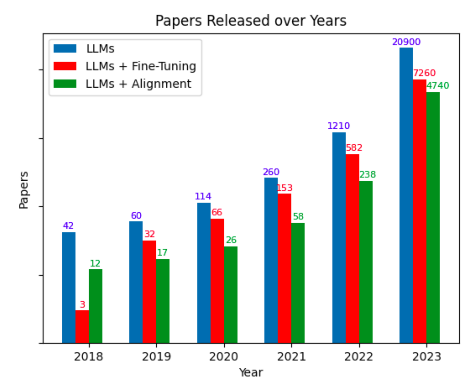

In [10]:
import base64
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt


for doc, _ in matching_docs:
    # Check if the page metadata is 'image'
    if doc.metadata['page'] == 'image':
        
        base64_image = doc.page_content
        image_data = base64.b64decode(base64_image)
        image = Image.open(BytesIO(image_data))
        
        # Display the image
        plt.imshow(image)
        plt.axis('off')
        plt.show()
    else:
        print(f"Document with source {doc.metadata['source']} is not an image.")

In [ ]:
retriever = db.as_retriever(search_type="similarity",search_kwargs={"k":3})
docs_rel = retriever.get_relevant_documents(query)

Text generation on top of the multi-modal semantic search, making it eventually multi-modal retrieval augmented generation (RAG) system

Open-source HuggingFaceHub Approach

In [ ]:
from getpass import getpass

HF_token = getpass() 
# HF accesskey at prompt. Generate accesstoken at https://huggingface.co/settings/tokens
os.environ['HUGGINGFACEHUB_API_TOKEN'] = HF_token

In [ ]:

# Taken from internet

prompt = f"""
<|system|>>
You are an AI Assistant that follows instructions extremely well.
Please be truthful and give direct answers. Please tell 'I don't know' if user query is not in context
</s>
<|user|>
{query}
</s>
<|assistant|>
"""


In [ ]:
from langchain.llms import HuggingFaceHub
from langchain.chains import RetrievalQA

model = HuggingFaceHub(repo_id="HuggingFaceH4/zephyr-7b-alpha",
					model_kwargs={"temperature":0.5,
									"max_new_tokens":512,
									"max_length":64
									})

qa = RetrievalQA.from_chain_type(llm=model,retriever=retriever,chain_type="stuff")
response = qa(prompt)
print(response['result'])



OpenAI

In [ ]:
# os.environ["OPENAI_API_KEY"] = "OPENAI_API_KEY"
# from langchain_openai import ChatOpenAI
# model_name = "gpt-3.5-turbo"
# llm = ChatOpenAI(model_name=model_name)
# from langchain.chains.question_answering import load_qa_chain
# chain = load_qa_chain(llm, chain_type="stuff",verbose=True)

# query = "What are the emotional benefits of owning a pet?"
# matching_docs = db.similarity_search(query)
# answer =  chain.run(input_documents=matching_docs, question=query)
# answer


In [ ]:
# from langchain.chains import RetrievalQA
# retrieval_chain = RetrievalQA.from_chain_type(llm, chain_type="stuff", retriever=db.as_retriever())
# retrieval_chain.run(query)
